In [1]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.utils import img_to_array
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
import random
import kagglehub

In [2]:
# Download latest version
path = kagglehub.dataset_download("andrewmvd/face-mask-detection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/face-mask-detection


In [4]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    annotations = []
    for obj in root.findall('object'):
        filename = root.find('filename').text
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        coords = {
            'xmin': int(bbox.find('xmin').text),
            'ymin': int(bbox.find('ymin').text),
            'xmax': int(bbox.find('xmax').text),
            'ymax': int(bbox.find('ymax').text)
        }
        annotations.append({'filename': filename, 'label': label, 'bbox': coords})
    return annotations


In [5]:
ANNOTATION_PATH = '/kaggle/input/face-mask-detection/annotations'
xml_files = [os.path.join(ANNOTATION_PATH, filename) for filename in os.listdir(ANNOTATION_PATH) if filename.endswith('.xml')]

In [6]:
data = []
for xml_file in xml_files:
    annotations = parse_xml(xml_file)

    for annotation in annotations:
        data.append([annotation['filename'], annotation['label'], annotation['bbox']])

In [7]:
df = pd.DataFrame(data, columns=['filename', 'label', 'bbox'])
df['label'].value_counts()

,count
label,
with_mask,3232
without_mask,717
mask_weared_incorrect,123


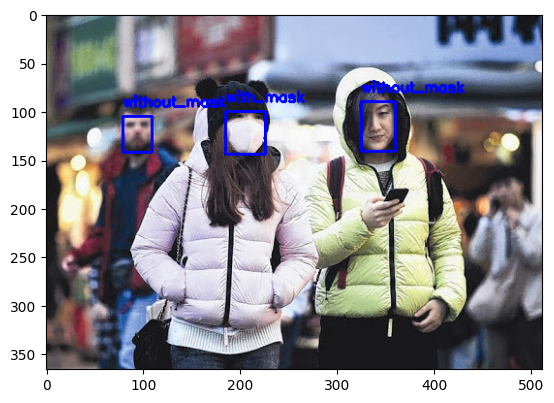

In [10]:
def visualize_annotation(image_path, annotations):
    image = cv2.imread(image_path)

    for ann in annotations:
        bbox = ann['bbox']
        cv2.rectangle(image, (bbox['xmin'], bbox['ymin']), (bbox['xmax'], bbox['ymax']), (255, 0, 0), 2)
        cv2.putText(image, ann['label'], (bbox['xmin'], bbox['ymin'] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
visualize_annotation('/kaggle/input/face-mask-detection/images/maksssksksss0.png', parse_xml('/kaggle/input/face-mask-detection/annotations/maksssksksss0.xml'))


In [11]:
IMAGE_PATH = '/kaggle/input/face-mask-detection/images/'
label_pair = {
    'with_mask': 0,
    'without_mask': 1,
    'mask_weared_incorrect': 2
}

face_images = []
face_labels = []

In [12]:
for i in range(len(df)):
    row = df.iloc[i]
    bbox = row['bbox']
    image = cv2.imread(IMAGE_PATH + row['filename'])
    image = image[bbox['ymin']:bbox['ymax'], bbox['xmin']:bbox['xmax']]
    image = cv2.resize(image, (224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    face_images.append(image)
    face_labels.append(label_pair[row['label']])

face_images = np.array(face_images, dtype='float32')
face_labels = np.array(face_labels)

In [25]:
train_x, test_val_x, train_y, test_val_y = train_test_split(face_images, face_labels, test_size=0.3, shuffle=True, stratify=face_labels)
test_x, val_x, test_y, val_y = train_test_split(test_val_x, test_val_y, test_size=0.5, shuffle=True, stratify=test_val_y)

print(train_x.shape, val_x.shape, test_x.shape)
print(train_y.shape, val_y.shape, test_y.shape)

(2850, 224, 224, 3) (611, 224, 224, 3) (611, 224, 224, 3)
(2850,) (611,) (611,)


In [26]:
from tensorflow.keras.utils import to_categorical

# One-hot encode the labels
train_y = to_categorical(train_y, num_classes=3)
val_y = to_categorical(val_y, num_classes=3)
test_y = to_categorical(test_y, num_classes=3)

print(train_y.shape, val_y.shape, test_y.shape)

(2850, 3) (611, 3) (611, 3)


In [48]:
# Build the convolutional autoencoder
input_img = tf.keras.Input(shape=(224, 224, 3))

In [63]:
# Encoder
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

In [64]:
# Decoder
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(3, (3, 3), activation='tanh', padding='same')(x)

In [65]:
# Autoencoder model
autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 28, 28, 16)          │           9,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_6 (UpSampling2D)       │ (None, 56, 56, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 56, 56, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_7 (UpSampling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_8 (UpSampling2D)       │ (None, 224, 224, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 224, 224, 3)         │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,683 (225.32 KB)

 Trainable params: 57,683 (225.32 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:
# Train the autoencoder
history_autoencoder = autoencoder.fit(train_x, train_x,
                                      epochs=10,
                                      batch_size=32,
                                      shuffle=True,
                                      validation_data=(val_x, val_x))

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - loss: 0.0716 - val_loss: 0.0062
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0052 - val_loss: 0.0044
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 10/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0014 - val_loss: 0.0015


In [ ]:
# Save the autoencoder model
model_save_path = 'face_mask_autoencoder.h5'
autoencoder.save(model_save_path)
print(f"Model saved to {model_save_path}")

In [68]:
# Extract the encoder model
encoder = tf.keras.Model(input_img, encoded)
encoder.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 28, 28, 64)          │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,584 (92.12 KB)

 Trainable params: 23,584 (92.12 KB)

 Non-trainable params: 0 (0.00 B)

In [75]:
# Freeze encoder layers to retain the learned features
for layer in encoder.layers:
    layer.trainable = False

# Build the classification model using the encoder
input_img_supervised = tf.keras.Input(shape=(224, 224, 3))
features = encoder(input_img_supervised)

# Global pooling to reduce spatial dimensions
x = tf.keras.layers.GlobalAveragePooling2D()(features)

# Flatten if you want to retain more detail
x = tf.keras.layers.Flatten()(features)

# Add fully-connected layers for classification
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(3, activation='softmax')(x)

# Create the full model
supervised_model = tf.keras.Model(inputs=input_img_supervised, outputs=output)
supervised_model.summary()

# Compile the model
supervised_model.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_14 (Functional)           │ (None, 28, 28, 64)          │          23,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 512)                 │      25,690,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,715,747 (98.10 MB)

 Trainable params: 25,692,163 (98.01 MB)

 Non-trainable params: 23,584 (92.12 KB)

In [78]:
history_supervised = supervised_model.fit(
    train_x, train_y,
    validation_data=(val_x, val_y),
    epochs=10,
    batch_size=32,
)

# Evaluate on test data
test_loss, test_acc = supervised_model.evaluate(test_x, test_y, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9238 - loss: 0.2186 - val_accuracy: 0.9296 - val_loss: 0.1942
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9348 - loss: 0.2036 - val_accuracy: 0.9411 - val_loss: 0.1881
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9374 - loss: 0.1952 - val_accuracy: 0.9460 - val_loss: 0.1638
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9364 - loss: 0.2005 - val_accuracy: 0.9394 - val_loss: 0.1820
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9239 - loss: 0.2536 - val_accuracy: 0.9345 - val_loss: 0.1793
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9283 - loss: 0.2220 - val_accuracy: 0.9264 - val_loss: 0.2463
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9303 - loss: 0.2350 - val_accuracy: 0.9345 - val_loss: 0.2035
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9288 - loss: 0.1998 - val_accuracy: 0.9378 - v

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get predictions for the test set
predictions = supervised_model.predict(test_x)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(test_y, axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


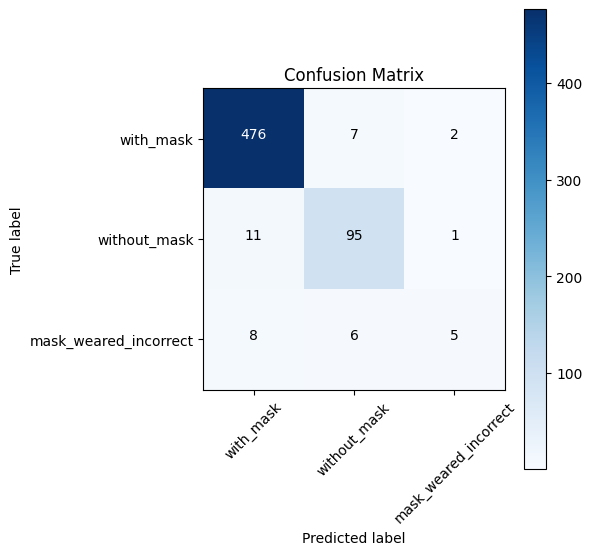

In [83]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define the label names
labels = ['with_mask', 'without_mask', 'mask_weared_incorrect']

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

# Add text annotations to each cell
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()